In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from information_estimation import *
from image_utils import *
from gaussian_process_utils import *

from led_array.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

Opening BSCCM
Opened BSCCM


In [3]:
# load images, extract patches, and compute cov mats
edge_crop = 32
patch_size = 10
num_images = 20000
channel = 'LED119'
eigenvalue_floor = 1e-3

num_test_images = 1000

all_images = load_bsccm_images(bsccm, channel=channel, num_images=num_images + num_test_images, edge_crop=edge_crop, median_filter=False)
images = all_images[:num_images]
test_images = all_images[num_images:]
test_patches = extract_patches(test_images, patch_size, num_patches=num_test_images, seed=0)

num_patches = 10000 
seed = 10 # this seed gives a bad initial fit
patches = extract_patches(images, patch_size, num_patches=num_patches, seed=seed)

### Do the optimization
batch_size = 12
momentum = 0.9
learning_rate = 1e-6

cov_mat_optimized, cov_mat_initial, mean_vec, best_loss, train_loss_history, val_loss_history, final_cov_mat = run_optimization(
    patches, momentum, learning_rate, batch_size, eigenvalue_floor=eigenvalue_floor, max_iters=1500, return_final=True)

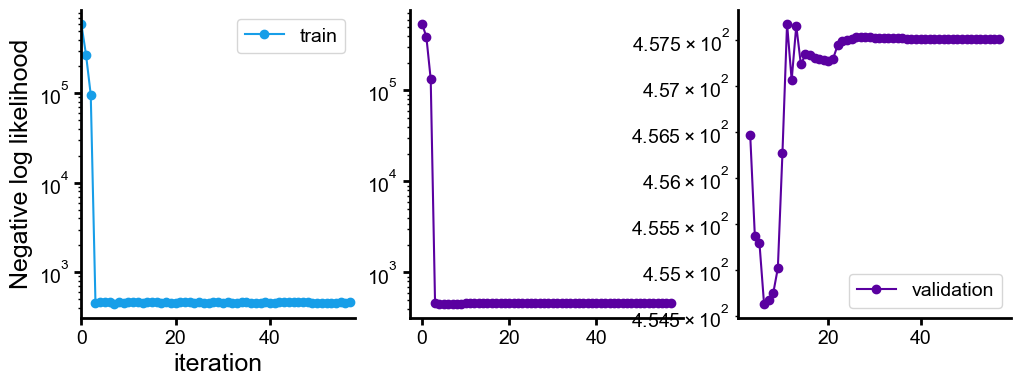

In [27]:
# plot loss history
offset = 3
iteration = np.arange(offset, len(train_loss_history))

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].semilogy(train_loss_history, '-o', label='train')
axs[0].legend()
axs[0].set(xlim=[0, len(train_loss_history)], xlabel='iteration', ylabel='Negative log likelihood')

axs[1].semilogy(val_loss_history, '-o', label='validation', color=get_color_cycle()[1])

axs[2].semilogy(iteration, val_loss_history[offset:], '-o', label='validation', color=get_color_cycle()[1])
axs[2].legend()


for a in axs:
    clear_spines(a)

In [28]:
sample_size = 40
num_samples = 8
prefer_iterative_sampling = False

samples_initial = generate_stationary_gaussian_process_samples(mean_vec, cov_mat_initial, num_samples=num_samples, sample_size=sample_size, 
        prefer_iterative_sampling=prefer_iterative_sampling, seed=None)
samples_optimized = generate_stationary_gaussian_process_samples(mean_vec, cov_mat_optimized, num_samples=num_samples, sample_size=sample_size,
        prefer_iterative_sampling=prefer_iterative_sampling,  seed=None)
samples_overfit = generate_stationary_gaussian_process_samples(mean_vec, final_cov_mat, num_samples=num_samples, sample_size=sample_size,
        prefer_iterative_sampling=prefer_iterative_sampling,  seed=None)

optimized_likelihood = compute_stationary_log_likelihood(test_patches, cov_mat_optimized, mean_vec).mean()
initial_likelihood = compute_stationary_log_likelihood(test_patches, cov_mat_initial, mean_vec).mean()
overfit_likelihood = compute_stationary_log_likelihood(test_patches, final_cov_mat, mean_vec).mean()

precomputing masks and variances: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


generating samples


precomputing masks and variances: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


generating samples


precomputing masks and variances: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


generating samples


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 192.98it/s]


evaluating likelihood


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 196.18it/s]


evaluating likelihood


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 206.28it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 10/10 [00:00<00:00, 186.44it/s]


Initial likelihood: -614612.0946196995
Optimized likelihood: -457.0238645831172
Overfit likelihood: -459.66548022476934


Text(0, 0.5, 'Eigenvalue')

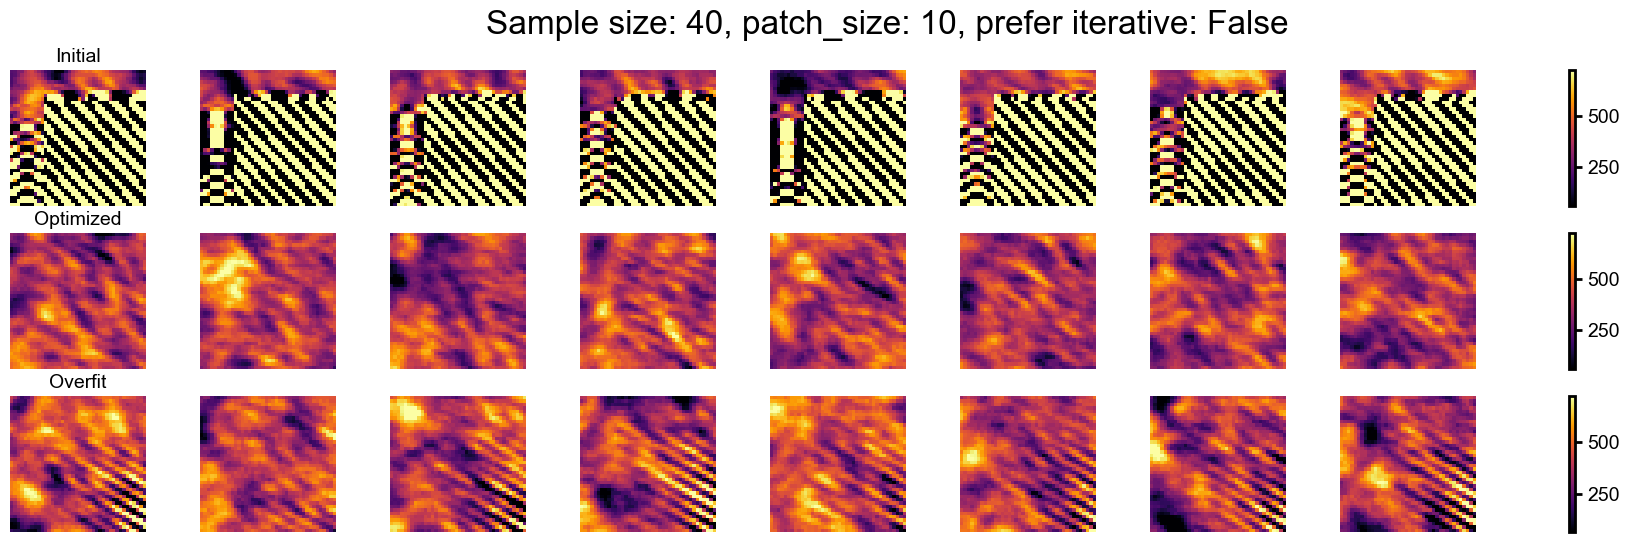

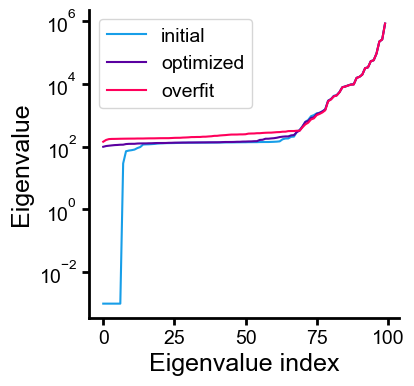

In [32]:

print(f'Initial likelihood: {initial_likelihood}')
print(f'Optimized likelihood: {optimized_likelihood}')
print(f'Overfit likelihood: {overfit_likelihood}')


fig, axs = plt.subplots(3, num_samples, figsize=(num_samples * 3, 6), sharex=True, sharey=True)
vmin_optimized, vmax_optimized = np.percentile(samples_optimized, .1), np.percentile(samples_optimized, 99.9)
for i in range(num_samples):
    im1 = axs[0, i].imshow(samples_initial[i], cmap='inferno', vmin=vmin_optimized, vmax=vmax_optimized)
    im2 = axs[1, i].imshow(samples_optimized[i], cmap='inferno', vmin=vmin_optimized, vmax=vmax_optimized)
    im3 = axs[2, i].imshow(samples_overfit[i], cmap='inferno', vmin=vmin_optimized, vmax=vmax_optimized)
    axs[0, i].axis('off')
    axs[1, i].axis('off')
    axs[2, i].axis('off')

axs[0, 0].set_title('Initial')
axs[1, 0].set_title('Optimized')
axs[2, 0].set_title('Overfit')

# add colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im1, cax=cbar_ax)
cbar_ax.set_ylabel('Photons')

fig.suptitle(f'Sample size: {sample_size}, patch_size: {patch_size}, prefer iterative: {prefer_iterative_sampling}')


# plot eignevalues of different cov mats
eig_vals_initial = np.linalg.eigvalsh(cov_mat_initial)
eig_vals_optimized = np.linalg.eigvalsh(cov_mat_optimized)
eig_vals_overfit = np.linalg.eigvalsh(final_cov_mat)

fig, axs = plt.subplots(1, 1, figsize=(4, 4))
axs.semilogy(eig_vals_initial, label='initial')
axs.semilogy(eig_vals_optimized, label='optimized')
axs.semilogy(eig_vals_overfit, label='overfit')
axs.legend()

clear_spines(axs)
axs.set_xlabel('Eigenvalue index')
axs.set_ylabel('Eigenvalue')

## Does DPC produce the same artifacts? 

In [33]:
# load images, extract patches, and compute cov mats
edge_crop = 32
patch_size = 10
num_images = 20000
channel = 'DPC_Right'
eigenvalue_floor = 1e-3

num_test_images = 1000

all_images = load_bsccm_images(bsccm, channel=channel, num_images=num_images + num_test_images, edge_crop=edge_crop, median_filter=False)
images = all_images[:num_images]
test_images = all_images[num_images:]
test_patches = extract_patches(test_images, patch_size, num_patches=num_test_images, seed=0)

num_patches = 10000 
seed = 10 # this seed gives a bad initial fit
patches = extract_patches(images, patch_size, num_patches=num_patches, seed=seed)


### Do the optimization
batch_size = 12
momentum = 0.9
learning_rate = 1e-6

cov_mat_optimized, cov_mat_initial, mean_vec, best_loss, train_loss_history, val_loss_history, final_cov_mat = run_optimization(
    patches, momentum, learning_rate, batch_size, eigenvalue_floor=eigenvalue_floor, max_iters=1500, return_final=True)

Initial loss:  934370.3048981153


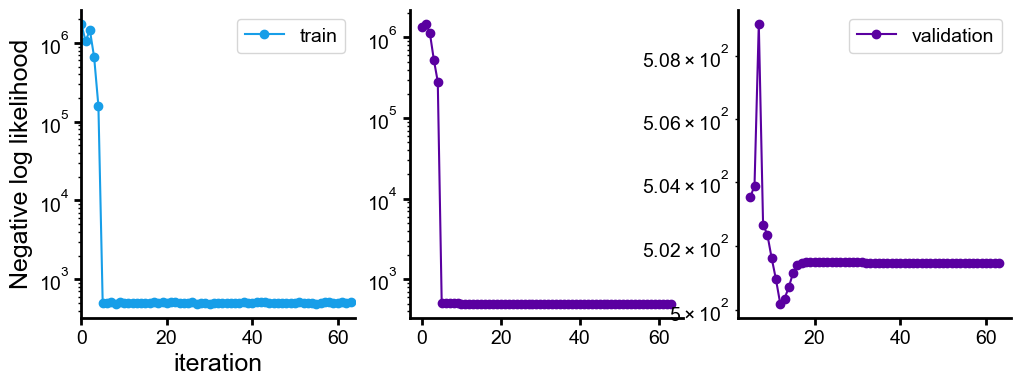

In [35]:
# plot loss history
offset = 5
iteration = np.arange(offset, len(train_loss_history))

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].semilogy(train_loss_history, '-o', label='train')
axs[0].legend()
axs[0].set(xlim=[0, len(train_loss_history)], xlabel='iteration', ylabel='Negative log likelihood')

axs[1].semilogy(val_loss_history, '-o', label='validation', color=get_color_cycle()[1])

axs[2].semilogy(iteration, val_loss_history[offset:], '-o', label='validation', color=get_color_cycle()[1])
axs[2].legend()


for a in axs:
    clear_spines(a)

In [36]:
sample_size = 40
num_samples = 8
prefer_iterative_sampling = False

samples_initial = generate_stationary_gaussian_process_samples(mean_vec, cov_mat_initial, num_samples=num_samples, sample_size=sample_size, 
        prefer_iterative_sampling=prefer_iterative_sampling, seed=None)
samples_optimized = generate_stationary_gaussian_process_samples(mean_vec, cov_mat_optimized, num_samples=num_samples, sample_size=sample_size,
        prefer_iterative_sampling=prefer_iterative_sampling,  seed=None)
samples_overfit = generate_stationary_gaussian_process_samples(mean_vec, final_cov_mat, num_samples=num_samples, sample_size=sample_size,
        prefer_iterative_sampling=prefer_iterative_sampling,  seed=None)

optimized_likelihood = compute_stationary_log_likelihood(test_patches, cov_mat_optimized, mean_vec).mean()
initial_likelihood = compute_stationary_log_likelihood(test_patches, cov_mat_initial, mean_vec).mean()
overfit_likelihood = compute_stationary_log_likelihood(test_patches, final_cov_mat, mean_vec).mean()

precomputing masks and variances: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


generating samples


precomputing masks and variances: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


generating samples


precomputing masks and variances: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


generating samples


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 186.41it/s]


evaluating likelihood


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 188.94it/s]


evaluating likelihood


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 206.51it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 10/10 [00:00<00:00, 179.16it/s]


Initial likelihood: -1204064.0796017777
Optimized likelihood: -499.6127764021777
Overfit likelihood: -501.18976325449404


Text(0, 0.5, 'Eigenvalue')

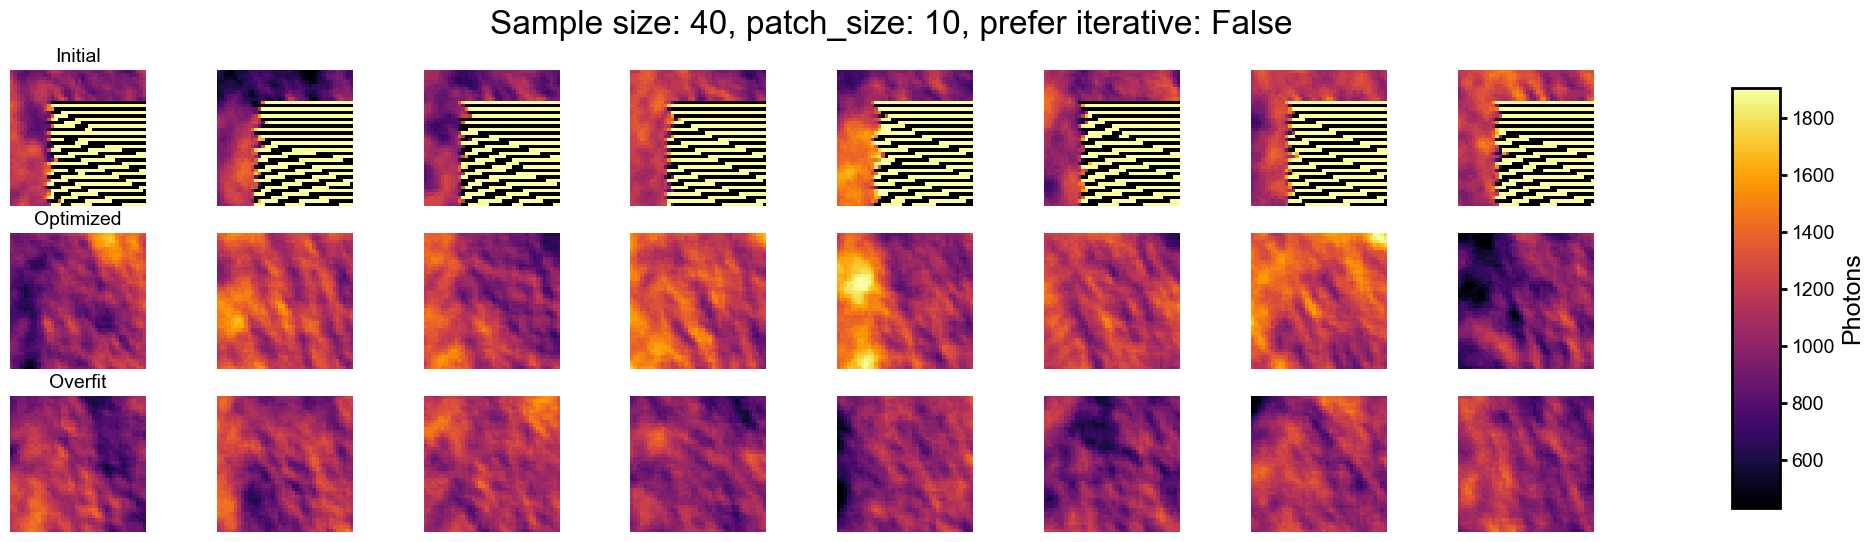

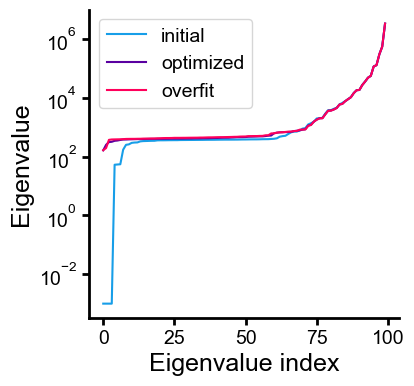

In [44]:
print(f'Initial likelihood: {initial_likelihood}')
print(f'Optimized likelihood: {optimized_likelihood}')
print(f'Overfit likelihood: {overfit_likelihood}')

fig, axs = plt.subplots(3, num_samples, figsize=(num_samples * 3, 6), sharex=True, sharey=True)
vmin_optimized, vmax_optimized = np.percentile(samples_optimized, .1), np.percentile(samples_optimized, 99.9)
for i in range(num_samples):
    im1 = axs[0, i].imshow(samples_initial[i], cmap='inferno', vmin=vmin_optimized, vmax=vmax_optimized)
    im2 = axs[1, i].imshow(samples_optimized[i], cmap='inferno', vmin=vmin_optimized, vmax=vmax_optimized)
    im3 = axs[2, i].imshow(samples_overfit[i], cmap='inferno', vmin=vmin_optimized, vmax=vmax_optimized)
    axs[0, i].axis('off')
    axs[1, i].axis('off')
    axs[2, i].axis('off')

axs[0, 0].set_title('Initial')
axs[1, 0].set_title('Optimized')
axs[2, 0].set_title('Overfit')

# add colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im1, cax=cbar_ax)
cbar_ax.set_ylabel('Photons')


fig.suptitle(f'Sample size: {sample_size}, patch_size: {patch_size}, prefer iterative: {prefer_iterative_sampling}')


# plot eignevalues of different cov mats
eig_vals_initial = np.linalg.eigvalsh(cov_mat_initial)
eig_vals_optimized = np.linalg.eigvalsh(cov_mat_optimized)
eig_vals_overfit = np.linalg.eigvalsh(final_cov_mat)

fig, axs = plt.subplots(1, 1, figsize=(4, 4))
axs.semilogy(eig_vals_initial, label='initial')
axs.semilogy(eig_vals_optimized, label='optimized')
axs.semilogy(eig_vals_overfit, label='overfit')
axs.legend()

clear_spines(axs)
axs.set_xlabel('Eigenvalue index')
axs.set_ylabel('Eigenvalue')

## Same thing when you way overfit to a small number of patches?

In [45]:
# load images, extract patches, and compute cov mats
edge_crop = 32
patch_size = 10
num_images = 1000
channel = 'LED119'
eigenvalue_floor = 1e-3

num_test_images = 1000

all_images = load_bsccm_images(bsccm, channel=channel, num_images=num_images + num_test_images, edge_crop=edge_crop, median_filter=False)
images = all_images[:num_images]
test_images = all_images[num_images:]
test_patches = extract_patches(test_images, patch_size, num_patches=num_test_images, seed=0)

num_patches = 10000 
seed = 10 # this seed gives a bad initial fit
patches = extract_patches(images, patch_size, num_patches=num_patches, seed=seed)



Initial loss:  482.60219800406117


In [51]:

### Do the optimization
batch_size = 12
momentum = 0.9
learning_rate = 1e-1

cov_mat_optimized, cov_mat_initial, mean_vec, best_loss, train_loss_history, val_loss_history, final_cov_mat = run_optimization(
    patches, momentum, learning_rate, batch_size, eigenvalue_floor=eigenvalue_floor, max_iters=1500, return_final=True)

Initial loss:  482.60219800406117
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3378, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_26641/3306381139.py", line 6, in <module>
    cov_mat_optimized, cov_mat_initial, mean_vec, best_loss, train_loss_history, val_loss_history, final_cov_mat = run_optimization(
  File "/home/hpinkard_waller/GitRepos/EncodingInformation/gaussian_process_utils.py", line 479, in run_optimization
    validation_loss = loss_function(eigvals, eig_vecs, mean_vec, validation_data)
  File "/home/hpinkard_waller/GitRepos/EncodingInformation/gaussian_process_utils.py", line 409, in loss_function
    ll = gaussian_likelihood(cov_mat, mean_vec, data)
  File "/home/hpinkard_waller/GitRepos/EncodingInformation/gaussian_process_utils.py", line 400, in gaussian_likelihood
    ll = jax.scipy.stats.multivariate_normal.logpdf(sample.reshape(-1), mean=mean_

: 

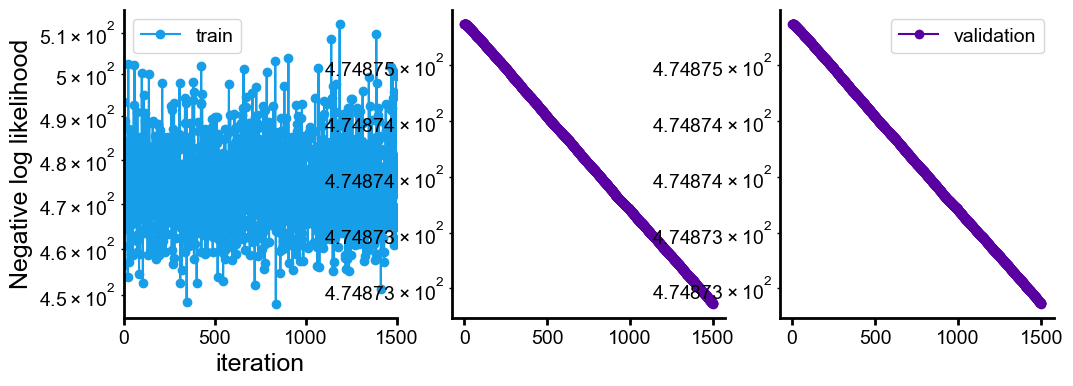

In [49]:
# plot loss history
offset = 3
iteration = np.arange(offset, len(train_loss_history))

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].semilogy(train_loss_history, '-o', label='train')
axs[0].legend()
axs[0].set(xlim=[0, len(train_loss_history)], xlabel='iteration', ylabel='Negative log likelihood')

axs[1].semilogy(val_loss_history, '-o', label='validation', color=get_color_cycle()[1])

axs[2].semilogy(iteration, val_loss_history[offset:], '-o', label='validation', color=get_color_cycle()[1])
axs[2].legend()


for a in axs:
    clear_spines(a)

In [47]:
sample_size = 40
num_samples = 8
prefer_iterative_sampling = False

samples_initial = generate_stationary_gaussian_process_samples(mean_vec, cov_mat_initial, num_samples=num_samples, sample_size=sample_size, 
        prefer_iterative_sampling=prefer_iterative_sampling, seed=None)
samples_optimized = generate_stationary_gaussian_process_samples(mean_vec, cov_mat_optimized, num_samples=num_samples, sample_size=sample_size,
        prefer_iterative_sampling=prefer_iterative_sampling,  seed=None)
samples_overfit = generate_stationary_gaussian_process_samples(mean_vec, final_cov_mat, num_samples=num_samples, sample_size=sample_size,
        prefer_iterative_sampling=prefer_iterative_sampling,  seed=None)

optimized_likelihood = compute_stationary_log_likelihood(test_patches, cov_mat_optimized, mean_vec).mean()
initial_likelihood = compute_stationary_log_likelihood(test_patches, cov_mat_initial, mean_vec).mean()
overfit_likelihood = compute_stationary_log_likelihood(test_patches, final_cov_mat, mean_vec).mean()

precomputing masks and variances: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


generating samples


precomputing masks and variances: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


generating samples


precomputing masks and variances: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


generating samples


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 190.98it/s]


evaluating likelihood


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 208.53it/s]


evaluating likelihood


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 193.56it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 10/10 [00:00<00:00, 182.73it/s]


Initial likelihood: -473.735185889304
Optimized likelihood: -473.7327940122962
Overfit likelihood: -473.7327940123366


Text(0, 0.5, 'Eigenvalue')

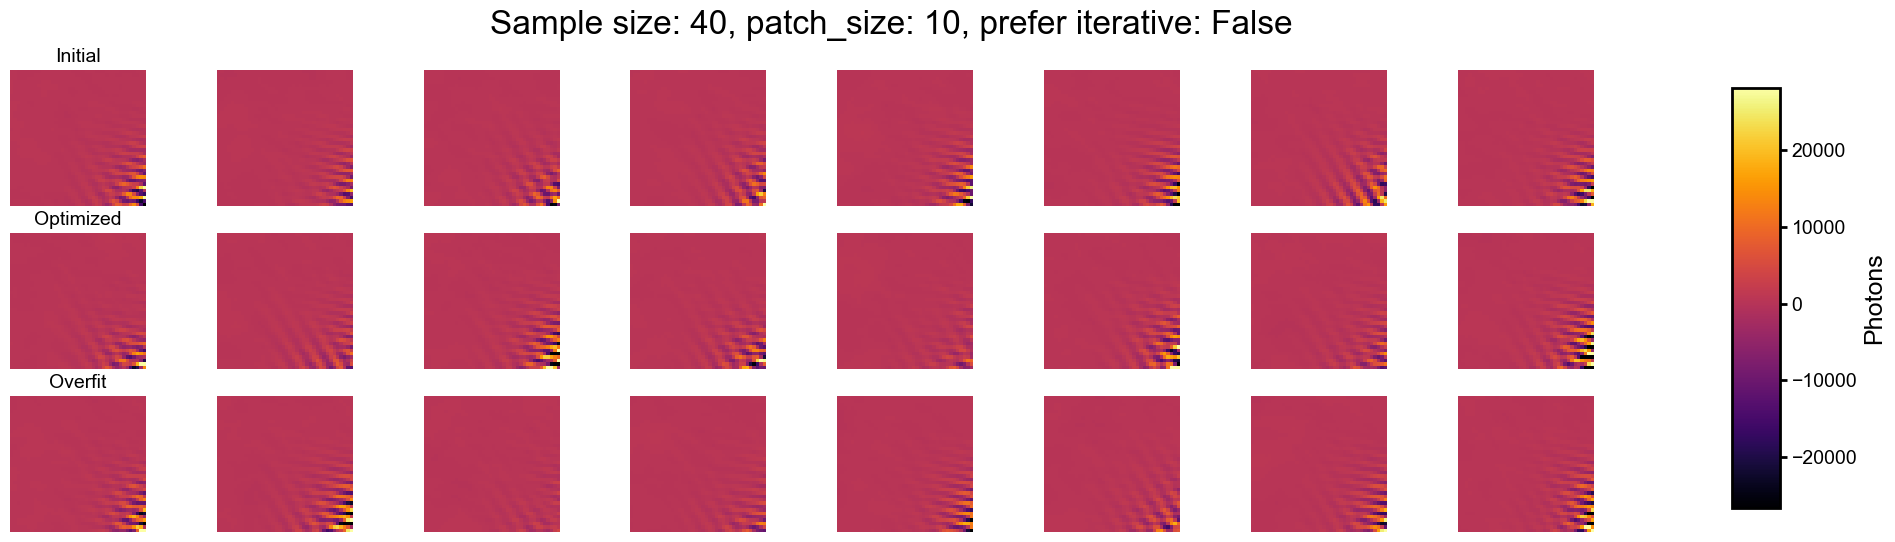

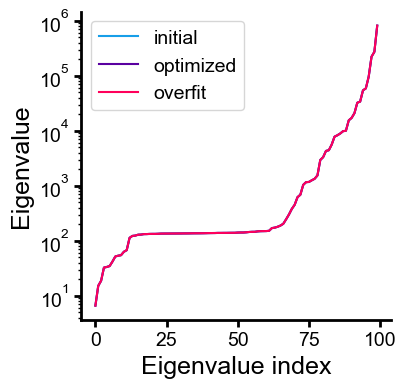

In [48]:
print(f'Initial likelihood: {initial_likelihood}')
print(f'Optimized likelihood: {optimized_likelihood}')
print(f'Overfit likelihood: {overfit_likelihood}')

fig, axs = plt.subplots(3, num_samples, figsize=(num_samples * 3, 6), sharex=True, sharey=True)
vmin_optimized, vmax_optimized = np.percentile(samples_optimized, .1), np.percentile(samples_optimized, 99.9)
for i in range(num_samples):
    im1 = axs[0, i].imshow(samples_initial[i], cmap='inferno', vmin=vmin_optimized, vmax=vmax_optimized)
    im2 = axs[1, i].imshow(samples_optimized[i], cmap='inferno', vmin=vmin_optimized, vmax=vmax_optimized)
    im3 = axs[2, i].imshow(samples_overfit[i], cmap='inferno', vmin=vmin_optimized, vmax=vmax_optimized)
    axs[0, i].axis('off')
    axs[1, i].axis('off')
    axs[2, i].axis('off')

axs[0, 0].set_title('Initial')
axs[1, 0].set_title('Optimized')
axs[2, 0].set_title('Overfit')

# add colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im1, cax=cbar_ax)
cbar_ax.set_ylabel('Photons')


fig.suptitle(f'Sample size: {sample_size}, patch_size: {patch_size}, prefer iterative: {prefer_iterative_sampling}')


# plot eignevalues of different cov mats
eig_vals_initial = np.linalg.eigvalsh(cov_mat_initial)
eig_vals_optimized = np.linalg.eigvalsh(cov_mat_optimized)
eig_vals_overfit = np.linalg.eigvalsh(final_cov_mat)

fig, axs = plt.subplots(1, 1, figsize=(4, 4))
axs.semilogy(eig_vals_initial, label='initial')
axs.semilogy(eig_vals_optimized, label='optimized')
axs.semilogy(eig_vals_overfit, label='overfit')
axs.legend()

clear_spines(axs)
axs.set_xlabel('Eigenvalue index')
axs.set_ylabel('Eigenvalue')

## Can you generate an even bigger patch?

In [ ]:
# load images, extract patches, and compute cov mats
edge_crop = 32
patch_size = 10
num_images = 20000
channel = 'LED119'
eigenvalue_floor = 1e-3

num_test_images = 1000

all_images = load_bsccm_images(bsccm, channel=channel, num_images=num_images + num_test_images, edge_crop=edge_crop, median_filter=False)
images = all_images[:num_images]
test_images = all_images[num_images:]
test_patches = extract_patches(test_images, patch_size, num_patches=num_test_images, seed=0)

num_patches = 10000 
seed = 10 # this seed gives a bad initial fit
patches = extract_patches(images, patch_size, num_patches=num_patches, seed=seed)


### Do the optimization
batch_size = 12
momentum = 0.9
learning_rate = 1e-6

cov_mat_optimized, cov_mat_initial, mean_vec, best_loss, train_loss_history, val_loss_history, final_cov_mat = run_optimization(
    patches, momentum, learning_rate, batch_size, eigenvalue_floor=eigenvalue_floor, max_iters=1500, return_final=True)

In [ ]:
# plot loss history
offset = 3
iteration = np.arange(offset, len(train_loss_history))

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].semilogy(train_loss_history, '-o', label='train')
axs[0].legend()
axs[0].set(xlim=[0, len(train_loss_history)], xlabel='iteration', ylabel='Negative log likelihood')

axs[1].semilogy(val_loss_history, '-o', label='validation', color=get_color_cycle()[1])

axs[2].semilogy(iteration, val_loss_history[offset:], '-o', label='validation', color=get_color_cycle()[1])
axs[2].legend()


for a in axs:
    clear_spines(a)

In [ ]:
sample_size = 80
num_samples = 8
prefer_iterative_sampling = False

samples_initial = generate_stationary_gaussian_process_samples(mean_vec, cov_mat_initial, num_samples=num_samples, sample_size=sample_size, 
        prefer_iterative_sampling=prefer_iterative_sampling, seed=None)
samples_optimized = generate_stationary_gaussian_process_samples(mean_vec, cov_mat_optimized, num_samples=num_samples, sample_size=sample_size,
        prefer_iterative_sampling=prefer_iterative_sampling,  seed=None)
samples_overfit = generate_stationary_gaussian_process_samples(mean_vec, final_cov_mat, num_samples=num_samples, sample_size=sample_size,
        prefer_iterative_sampling=prefer_iterative_sampling,  seed=None)

optimized_likelihood = compute_stationary_log_likelihood(test_patches, cov_mat_optimized, mean_vec).mean()
initial_likelihood = compute_stationary_log_likelihood(test_patches, cov_mat_initial, mean_vec).mean()
overfit_likelihood = compute_stationary_log_likelihood(test_patches, final_cov_mat, mean_vec).mean()

In [ ]:
print(f'Initial likelihood: {initial_likelihood}')
print(f'Optimized likelihood: {optimized_likelihood}')
print(f'Overfit likelihood: {overfit_likelihood}')

fig, axs = plt.subplots(3, num_samples, figsize=(num_samples * 3, 6), sharex=True, sharey=True)
vmin_optimized, vmax_optimized = np.percentile(samples_optimized, .1), np.percentile(samples_optimized, 99.9)
for i in range(num_samples):
    im1 = axs[0, i].imshow(samples_initial[i], cmap='inferno', vmin=vmin_optimized, vmax=vmax_optimized)
    im2 = axs[1, i].imshow(samples_optimized[i], cmap='inferno', vmin=vmin_optimized, vmax=vmax_optimized)
    im3 = axs[2, i].imshow(samples_overfit[i], cmap='inferno', vmin=vmin_optimized, vmax=vmax_optimized)
    axs[0, i].axis('off')
    axs[1, i].axis('off')
    axs[2, i].axis('off')

axs[0, 0].set_title('Initial')
axs[1, 0].set_title('Optimized')
axs[2, 0].set_title('Overfit')

# add colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im1, cax=cbar_ax)
cbar_ax.set_ylabel('Photons')


fig.suptitle(f'Sample size: {sample_size}, patch_size: {patch_size}, prefer iterative: {prefer_iterative_sampling}')


# plot eignevalues of different cov mats
eig_vals_initial = np.linalg.eigvalsh(cov_mat_initial)
eig_vals_optimized = np.linalg.eigvalsh(cov_mat_optimized)
eig_vals_overfit = np.linalg.eigvalsh(final_cov_mat)

fig, axs = plt.subplots(1, 1, figsize=(4, 4))
axs.semilogy(eig_vals_initial, label='initial')
axs.semilogy(eig_vals_optimized, label='optimized')
axs.semilogy(eig_vals_overfit, label='overfit')
axs.legend()

clear_spines(axs)
axs.set_xlabel('Eigenvalue index')
axs.set_ylabel('Eigenvalue')